In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
import torch.nn as nn
import torch.nn.functional as F
from nltk.corpus import stopwords 
from collections import Counter
import string
import torch.optim as optim

import re
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
import time

In [2]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [4]:
from nltk.corpus import stopwords
import collections
from collections import Counter

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
device

device(type='cuda')

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
data= pd.read_csv("/content/drive/MyDrive/senti_datasets/train.csv")
data.head()

,text_id,sentence,gold_label
0,r1-0051002,"Cheers,\n\nDennis Nguyen\n416-879-6431",0
1,r1-0020356,May have to wait longer on holidays.,-1
2,r1-0058348,"I drove to vegas may 6th, to get my hair done.",0
3,r1-0080006,"In addition, I eat out often at various restau...",1
4,r1-0000827,Perhaps she was doing us a favor?,0


In [9]:
train_data, test_data = train_test_split(data, test_size=0.10)
x_train=train_data['sentence']
y_train=train_data['gold_label']
x_test=train_data['sentence']
y_test=train_data['gold_label']

In [10]:
def preprocess_string(s):
    # Remove all non-word characters (everything except numbers and letters)
    s = re.sub(r"[^\w\s]", '', s)
    # Replace all runs of whitespaces with no space
    s = re.sub(r"\s+", '', s)
    # replace digits with no space
    s = re.sub(r"\d", '', s)

    return s

def tockenize(x_train,y_train,x_val,y_val):
    word_list = []

    stop_words = set(stopwords.words('english')) 
    for sent in data['sentence']:
        for word in sent.lower().split():
            word = preprocess_string(word)
            if word not in stop_words and word != '':
                word_list.append(word)
  
    corpus = Counter(word_list)
    # sorting on the basis of most common words
    corpus_ = sorted(corpus,key=corpus.get,reverse=True)[:40000]
    # creating a dict
    onehot_dict = {w:i+1 for i,w in enumerate(corpus_)}
    
    # tockenize
    final_list_train,final_list_test = [],[]
    for sent in x_train:
            final_list_train.append([onehot_dict[preprocess_string(word)] for word in sent.lower().split() 
                                     if preprocess_string(word) in onehot_dict.keys()])
    for sent in x_val:
            final_list_test.append([onehot_dict[preprocess_string(word)] for word in sent.lower().split() 
                                    if preprocess_string(word) in onehot_dict.keys()])

   
    return np.array(final_list_train),np.array(final_list_test),onehot_dict

In [11]:
x_train,x_test,vocab = tockenize(x_train,y_train,x_test,y_test)

<ipython-input-10-6e9787626bf2>:37: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(final_list_train),np.array(final_list_test),onehot_dict


In [12]:
y_train

25456    1
18774    1
15358   -1
72517   -1
23327    1
        ..
90673   -1
77469    0
24131    0
16457   -1
77900   -1
Name: gold_label, Length: 83005, dtype: int64

In [13]:
len(vocab)

33755

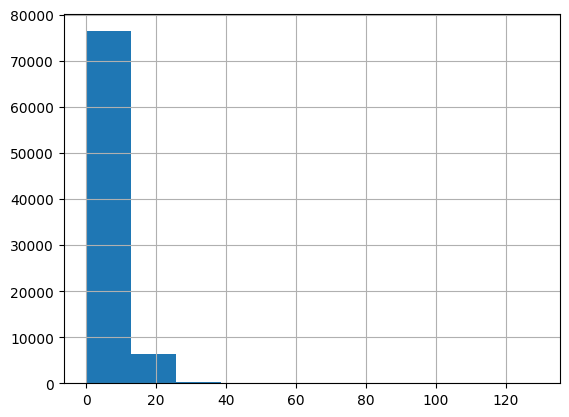

count    83005.000000
mean         6.577206
std          4.149158
min          0.000000
25%          4.000000
50%          6.000000
75%          9.000000
max        129.000000
dtype: float64

In [14]:
rev_len = [len(i) for i in x_train]
pd.Series(rev_len).hist()
plt.show()
pd.Series(rev_len).describe()


In [15]:
def padding_(sentences, seq_len):
    features = np.zeros((len(sentences), seq_len),dtype=int)
    for ii, review in enumerate(sentences):
        if len(review) != 0:
            features[ii-1, -len(review):] = np.array(review)[:seq_len]
    return features

In [16]:
test_data['neu']=np.zeros(len(test_data))
test_data['neg']=np.zeros(len(test_data))
test_data['pos']=np.zeros(len(test_data))
train_data['neu']=np.zeros(len(train_data))
train_data['neg']=np.zeros(len(train_data))
train_data['pos']=np.zeros(len(train_data))
train_data['neu']=train_data['gold_label']==0
train_data['neg']=train_data['gold_label']==-1
train_data['pos']=train_data['gold_label']==1
train_data['neu']=train_data['neu'].astype(float)
train_data['neg']=train_data['neg'].astype(float)
train_data['pos']=train_data['pos'].astype(float)
test_data['neu']=test_data['gold_label']==0
test_data['neg']=test_data['gold_label']==-1
test_data['pos']=test_data['gold_label']==1
test_data['neu']=test_data['neu'].astype(float)
test_data['neg']=test_data['neg'].astype(float)
test_data['pos']=test_data['pos'].astype(float)

In [17]:
train_y = (train_data[['neg','neu','pos']].values)
test_y = (test_data[['neg','neu','pos']].values)

In [18]:
test_y

array([[0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       ...,
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.]])

In [52]:
x_train_pad = padding_(x_train,80)
x_test_pad = padding_(x_test,80)

train_data = TensorDataset(torch.tensor(x_train_pad, dtype=torch.long).cuda(),torch.tensor(train_y, dtype=torch.float).cuda())
#test_data = TensorDataset(torch.from_numpy(x_test_pad).cuda(), torch.from_numpy(np.array(test_y,dtype=float)).cuda())
print(train_data)
# dataloaders
batch_size = 50
# make sure to SHUFFLE your data
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
#valid_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size)

In [69]:
class RNN_Text(nn.Module):
    
    def __init__(self):
         super(RNN_Text, self).__init__()
         hidden_size = 64
         num_layers = 4
         output_dim = 3
         self.embedding = nn.Embedding(max, embedding_dim)
         self.rnn = nn.LSTM(input_size=embedding_dim, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
         self.fc1 = nn.Linear(hidden_size, output_dim)

    def forward(self, x):
         x = self.embedding(x)
         output, hidden = self.rnn(x)
         x = output[:, -1, :]  # take the final hidden state
         x = self.fc1(x)

         return x

In [70]:
n_epochs = 5
max= 50000
vocab_size=len(vocab)
embedding_dim= 256
hidden_size= 1024
num_layers= 2
output_dim= 3
model = RNN_Text()
''''def loss_f(outputs, targets):
    return torch.nn.BCEWithLogitsLoss()(outputs, targets)'''
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)

criterion = nn.BCEWithLogitsLoss()

model = model.to(device)
criterion = criterion.to(device)

In [71]:
train_loss = []
valid_loss = []

for epoch in range(n_epochs):
    start_time = time.time()
    # Set model to train configuration
    model.train()
    avg_loss = 0.  
    for i, (x_batch, y_batch) in enumerate(train_loader):
        # Predict/Forward Pass
        y_pred = model(x_batch)
        # Compute loss
        loss = loss_f(y_pred, y_batch.float())
        #print(loss)
        #print(y_pred)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        avg_loss += loss.item() / len(train_loader)
    print(epoch)
    print(avg_loss)
    torch.save(model, '/content/drive/MyDrive/Colab Notebooks/sentana3.pth')

0
0.6060124458066685
1
0.6052288674647947
2
0.6026562537722105
3
0.5835640625663726
4
0.5379330800966209


In [72]:
dev=pd.read_csv('/content/drive/MyDrive/senti_datasets_1/test.csv')

In [73]:
x=dev['sentence']


In [74]:
x

0       A helpful valet at the Bellagio said it was a ...
1       People often ask "what happened to the human c...
2       He explained there would be a diagnostic fee o...
3         I had initially purchased a massage on Groupon.
4       Primarily do high-end cars as they get referra...
                              ...                        
5105        I forget for a little while I am in a desert.
5106    And I've tried most everything in the case, co...
5107    I mean who wouldn't after taking boot camp cla...
5108    My husband and I could hardly choose which dis...
5109    The front desk is a bit ok, but the manager we...
Name: sentence, Length: 5110, dtype: object

In [75]:
def preprocess_string(s):
    # Remove all non-word characters (everything except numbers and letters)
    s = re.sub(r"[^\w\s]", '', s)
    # Replace all runs of whitespaces with no space
    s = re.sub(r"\s+", '', s)
    # replace digits with no space
    s = re.sub(r"\d", '', s)

    return s

def tocken(x_train):
    word_list = []

    stop_words = set(stopwords.words('english')) 
    for sent in x_train:
        for word in sent.lower().split():
            word = preprocess_string(word)
            if word not in stop_words and word != '':
                word_list.append(word)
  
    corpus = Counter(word_list)
    # sorting on the basis of most common words
    corpus_ = sorted(corpus,key=corpus.get,reverse=True)[:40000]
    # creating a dict
    onehot_dict = {w:i+1 for i,w in enumerate(corpus_)}
    
    # tockenize
    final_list=[]
    for sent in x_train:
      #print(sent)
      final_list.append([onehot_dict[preprocess_string(word)] for word in " ".join(sent).lower().split() 
                             if preprocess_string(word) in onehot_dict.keys()])

    

    
    return np.array(final_list)

In [76]:
x_f = tocken(x)

<ipython-input-75-02d3828898d8>:37: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(final_list)


In [77]:
x_t=padding_(x_f,80)

In [78]:
len(x)

5110

In [79]:
x_cv = torch.tensor(x_t, dtype=torch.long).cuda()
valid = torch.utils.data.TensorDataset(x_cv)
valid_loader = torch.utils.data.DataLoader(valid, batch_size=64, shuffle=False)

model.eval()
y_hat=[]
batch_size=64
val_preds = np.zeros((len(x_cv),3))
for i, (x_batch) in enumerate(valid_loader):
        #print(x_batch[0])
        y_pred = model(x_batch[0]).detach()
        print(y_pred)
        val_preds[i * batch_size:(i+1) * batch_size] =F.softmax(y_pred).cpu().numpy()
y_hat=(val_preds.argmax(axis=1))

y_hat[:100]

k=0
with open('/content/answer12.txt', 'w') as f:
    for i in (y_hat-1):
        f.write(str(i))
        k+=1
        if k==5110:
          break
        f.write('\n')


len(data)==5110

tensor([[-0.3289, -3.0117,  0.1286],
        [ 0.2542, -3.6256, -0.1915],
        [ 0.1186, -3.8158,  0.0287],
        [ 0.1996, -3.4158, -0.1155],
        [ 0.3158, -3.7543, -0.1601],
        [-0.5278, -1.8372,  0.0113],
        [ 0.3072, -3.7649, -0.1669],
        [-3.1931,  2.0539, -2.4707],
        [-2.2379,  1.0335, -1.6509],
        [-0.2178, -2.8461,  0.1401],
        [ 0.2914, -3.7021, -0.1863],
        [ 0.3179, -3.7901, -0.1592],
        [ 0.2651, -3.6646, -0.1680],
        [-1.5486,  0.2817, -1.0752],
        [ 0.2788, -3.7066, -0.1920],
        [-0.3851, -2.0553,  0.0552],
        [-3.1821,  2.0354, -2.4715],
        [-1.9607,  0.7725, -1.4460],
        [-0.6104, -1.2696, -0.1813],
        [-0.2325, -2.9464,  0.1084],
        [ 0.3464, -3.7968, -0.1441],
        [-0.6466, -1.4302, -0.1473],
        [-0.6366, -1.5025, -0.1244],
        [-1.0495, -0.4893, -0.7658],
        [-2.1187,  0.9333, -1.5708],
        [-1.4768,  0.2026, -1.0160],
        [ 0.2879, -3.6775, -0.1917],
 

<ipython-input-79-9c7124bcb187>:13: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  val_preds[i * batch_size:(i+1) * batch_size] =F.softmax(y_pred).cpu().numpy()


tensor([[ 2.4189e-01, -3.6328e+00, -1.4748e-01],
        [-6.2420e-01, -1.6895e+00, -1.0886e-01],
        [ 1.9163e-01, -3.8181e+00, -6.1632e-04],
        [-6.2518e-01, -1.2858e+00, -3.8098e-01],
        [-6.2532e-02, -3.6798e+00,  1.1596e-01],
        [-2.6016e+00,  1.4422e+00, -2.0114e+00],
        [ 2.6925e-01, -3.8290e+00, -5.7850e-02],
        [ 2.4659e-01, -3.8844e+00, -4.5110e-02],
        [-2.0729e-01, -2.8331e+00,  1.8226e-01],
        [-6.0782e-01, -1.5730e+00, -8.8687e-02],
        [-6.8364e-01, -1.3001e+00, -1.9980e-01],
        [ 2.8473e-01, -3.7099e+00, -1.5290e-01],
        [-2.3898e-01, -2.6152e+00,  1.8940e-01],
        [ 2.7970e-01, -3.6667e+00, -1.1998e-01],
        [-2.1394e+00,  9.6073e-01, -1.5929e+00],
        [-2.5631e-01, -2.9483e+00,  1.6732e-01],
        [ 2.7703e-01, -3.6478e+00, -1.8227e-01],
        [-1.0591e+00, -3.9057e-01, -6.3814e-01],
        [-1.4880e-02, -2.8872e+00,  7.1908e-03],
        [-8.2491e-01, -8.9312e-01, -3.7996e-01],
        [ 3.2514e-01

False